# Предсказание уровня сложности фильма на английском языке

## Оглавление
1. [Загрузка данных](#paragraph1)    
2. [Предобработка данных](#paragraph2)  
3. [Исследовательский анализ данных](#paragraph3)  
4. [Разработка модели](#paragraph4)  
    4.1 [Подготовка набора данных](#subparagraph1)  
    4.2 [Векторизация признаков](#subparagraph2)  
    4.3 [Обучение и тестирование модели](#subparagraph3)  
5. [Сохранение результатов](#paragraph5)  

In [609]:
! pip install pysrt

In [610]:
! pip install catboost

In [611]:
import pysrt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

[nltk_data] Downloading package punkt to C:\Users\Дом-
[nltk_data]     ПК\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Дом-
[nltk_data]     ПК\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Дом-
[nltk_data]     ПК\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a name="paragraph1"></a>

## 1. Загрузка данных

In [612]:
films = pd.read_excel('D:/DS+/Мастерская/English Level/English_level/movies_labels.xlsx')
films.head()

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [613]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      511 non-null    int64 
 1   Movie   511 non-null    object
 2   Level   511 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.1+ KB


In [614]:
films.columns

Index(['id', 'Movie', 'Level'], dtype='object')

In [615]:
films = films.drop('id', axis=1)
films.head()

,Movie,Level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [616]:
path = 'D:/DS+/Мастерская/English Level/English_level/Subtitles/'

In [617]:
for i in range(films.shape[0]):
    subs = pysrt.open(path + films['Movie'].values[i] + '.srt', encoding='latin-1')
    films.loc[i,'Subtitles'] = subs.text

In [618]:
films.head(10)

,Movie,Level,Subtitles
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct..."
4,Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."
5,All_dogs_go_to_heaven(1989),A2/A2+,CAPTIONING MADE POSSIBLE BY\nMGM HOME ENTERTAI...
6,An_American_tail(1986),A2/A2+,(INDISTINCT CONVERSATION)\n(ALL LAUGHING)\nMAM...
7,Babe(1995),A2/A2+,This is a tale about<br/>an unprejudiced heart...
8,Back_to_the_future(1985),A2/A2+,"October is inventory time,\nso right now, Stat..."
9,Banking_On_Bitcoin(2016),C1,Downloaded from\nYTS.MX\nOfficial YIFY movies ...


<a name="paragraph2"></a>

## 2. Предобработка

 Для преобразования данных наипишим функцию `preprocessing`, выполняющую несколько этапов:  
 - очистка текста от тегов, комментариев, знаков препинания и тд.;  
 - получение списка уникальных слов;  
 - проведение лемматизации уникальных слов.   
 Предварительно переименуем название признаков.

In [619]:
films = films.rename(columns={'Movie': 'movie', 'Level': 'level', 'Subtitles': 'subtitles'})

In [620]:
HTML = r'<.*?>' # html тэги меняем на пробел
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
UPPER = r'[[A-Za-z ]+[\:\]]' # указания на того кто говорит (BOBBY:)
LETTERS = r'[^a-zA-Z\'.,!? ]' # все что не буквы меняем на пробел
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа

In [621]:
def preprocessing(subs):
    subs = subs[1:] # удаляем первый рекламный субтитр
    txt = re.sub(HTML, ' ', subs) # html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) # html тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
    txt = re.sub(UPPER, ' ', txt) # указания на того кто говорит (BOBBY:)
    txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
    txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
    txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
    txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
    txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
    txt = txt.lstrip() # обрезка пробелов слева
    txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы  
    txt = txt.lower() # текст в нижний регистр
    txt = txt.replace('"', '')
    
#Получаем список уникальных слов:
    txt = txt.split()
    txt_unique = ' '.join(list(set(txt)))

#Лемматизация уникальных слов:
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(txt_unique)
    lemmatized_txt = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    return lemmatized_txt 

In [622]:
films['words_lemm'] = films['subtitles'].apply(preprocessing)

In [623]:
films.head()

,movie,level,subtitles,words_lemm
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...",their be generosity r spent hardware walk brig...
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",disgusting spent blind friend maybe absolutely...
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,spent blind chaucer maybe thousand riding abso...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct...",friend history maybe news unreal hope gosh are...
4,Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac...",disgusting friend history maybe quos riding al...


<a name="paragraph3"></a>

## 3. Исследовательский анализ данных

Проверим целевой признак:

In [624]:
films['level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2', 'A1',
       'B2, C1'], dtype=object)

Проведем следующие замены:  
- Уровень 'A2/A2+' заменим на 'А2';  
- Уровень 'A2/A2+, B1' заменим на 'B1';  
- Уровень 'B1, B2' заменим на 'B2';
- Уровень 'B2, С1' заменим на 'С1';

In [625]:
films['level'] = films['level'].replace({'A2/A2+': 'A2', 'A2/A2+, B1': 'B1', 'B1, B2': 'B2', 'B2, C1': 'C1'})

In [626]:
films['level'].unique()

array(['B1', 'B2', 'A2', 'C1', 'A1'], dtype=object)

In [627]:
films['level'].value_counts()

A2    172
B2    137
B1     89
C1     70
A1     43
Name: level, dtype: int64

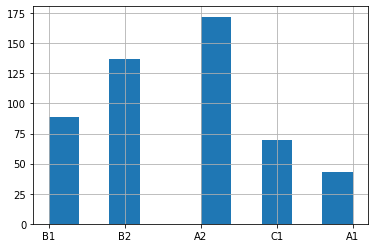

In [628]:
films['level'].hist()
plt.show()

**Вывод:** присутствует дисбаланс классов. Отсутствуют класс С2

Проверим количество уникальных слов по уровням:

In [629]:
films['words_unique_num'] = films['words_lemm'].str.count(' ') + 1

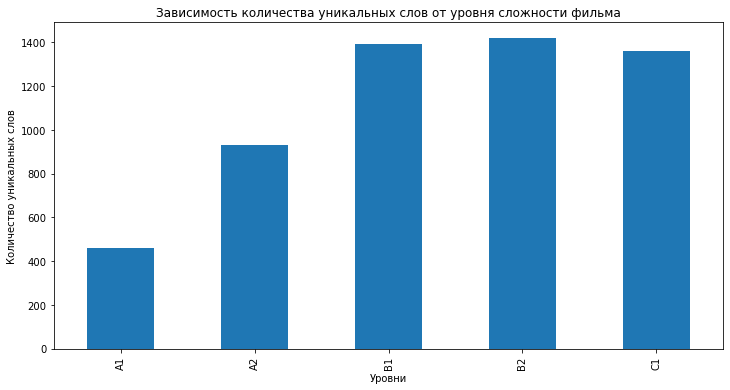

In [630]:
films.groupby('level')['words_unique_num'].agg('mean').plot(y=['words_unique_num'], figsize=(12,6), kind='bar')
plt.title('Зависимость количества уникальных слов от уровня сложности фильма')
plt.xlabel('Уровни')
plt.ylabel('Количество уникальных слов')
plt.show()

**Вывод:** Для уровней А1 и А2 количество уникальных слов значительно ниже, чем для уровней В1, В2 и С1.

<a name="paragraph4"></a>

## 4. Обучение модели

Для прогнозирования сложности фильма будем использовать модель по алгоритму градиентного бустинга из библиотеки Catboost. Для оценки качества предсказания используем метрику F1. Предварительно подготовим наборы данных и проведем векторизацию с помощью инструмента Tf-idf.

<a name="subparagraph1"></a>

### 4.1 Подготовка набора данных

In [631]:
X = films['words_lemm']
y = films['level']

In [632]:
RANDOM_STATE = 25

In [633]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 357 entries, 273 to 132
Series name: words_lemm
Non-Null Count  Dtype 
--------------  ----- 
357 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB


Проведем сброс индексов в выборках:

In [634]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [635]:
X_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 357 entries, 0 to 356
Series name: words_lemm
Non-Null Count  Dtype 
--------------  ----- 
357 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB


<a name="subparagraph2"></a>

### 4.2 Векторизация признаков

In [636]:
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words="english")

In [637]:
values_train = vectorizer.fit_transform(X_train)

In [640]:
X_train = pd.DataFrame(values_train.toarray(), columns=vectorizer.get_feature_names_out())

In [641]:
X_train.shape

(357, 32840)

Проведем преобразование тестовой выборки:

In [642]:
values_test = vectorizer.transform(X_test)

In [643]:
X_test = pd.DataFrame(values_test.toarray(), columns=vectorizer.get_feature_names_out())

In [645]:
X_test.shape

(154, 32840)

Удалим из итоговых наборов данных исходный текстовый признак `words_lemm`:

<a name="subparagraph3"></a>

### 3.3. Обучение модели и тестирование модели

In [648]:
model = CatBoostClassifier(iterations=150, loss_function='MultiClass', eval_metric='TotalF1')
model.fit(X_train, y_train, verbose=10)

Learning rate set to 0.373003
0:	learn: 0.5216093	total: 6.85s	remaining: 17m
10:	learn: 0.7554926	total: 29.3s	remaining: 6m 9s
20:	learn: 0.8872410	total: 51.9s	remaining: 5m 19s
30:	learn: 0.9718930	total: 1m 17s	remaining: 4m 58s
40:	learn: 0.9887797	total: 1m 41s	remaining: 4m 28s
50:	learn: 1.0000000	total: 2m 3s	remaining: 4m
60:	learn: 1.0000000	total: 2m 27s	remaining: 3m 34s
70:	learn: 1.0000000	total: 2m 49s	remaining: 3m 8s
80:	learn: 1.0000000	total: 3m 13s	remaining: 2m 44s
90:	learn: 1.0000000	total: 3m 35s	remaining: 2m 19s
100:	learn: 1.0000000	total: 3m 59s	remaining: 1m 56s
110:	learn: 1.0000000	total: 4m 22s	remaining: 1m 32s
120:	learn: 1.0000000	total: 4m 45s	remaining: 1m 8s
130:	learn: 1.0000000	total: 5m 7s	remaining: 44.7s
140:	learn: 1.0000000	total: 5m 30s	remaining: 21.1s
149:	learn: 1.0000000	total: 5m 51s	remaining: 0us


In [649]:
y_pred = model.predict(X_test)

In [650]:
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.6746192613395368

<a name="paragraph5"></a>

## 5. Сохранение результатов

In [651]:
model.save_model('D:/DS+/Мастерская/English Level/catboost_model.bin')
print('Модель сохранена')

Модель сохранена


In [652]:
pickle.dump(vectorizer, open('D:/DS+/Мастерская/English Level/vectorizer.pcl', "wb"))
print('Модель сохранена')

Модель сохранена
